In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_object_dtype
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

In [144]:
df_1 = pd.read_csv("breast_cancer_1st.csv")
df_2 = pd.read_csv("breast_cancer_2st.csv")
df_3 = pd.read_csv("breast_cancer_3st.csv")
df_4 = pd.read_csv("breast_cancer_4st.csv")

df = pd.concat([df_1, df_2, df_3, df_4], ignore_index=True)

In [145]:
df.head()

,patient_id,stage,age,gender,menopausal_status,family_history,molecular_subtype,er_status,pr_status,her2_status,...,tumor_size_12m,tumor_size_24m,has_metastasis,metastasis_sites,survival_months,performance_status,tumor_grade,lymph_node_status,positive_lymph_nodes,treatment_response
0,BC_1_0001,1,59,Ж,postmenopausal,False,HR+HER2-,True,True,False,...,"1,1","1,1",False,none,98,0,1,negative,0,stable
1,BC_1_0002,1,46,Ж,premenopausal,True,TNBC,False,False,False,...,"0,9","0,9",False,none,"61,8",0,2,negative,0,stable
2,BC_1_0003,1,60,Ж,postmenopausal,False,TNBC,False,False,False,...,"1,1","1,1",False,none,"112,9",2,2,negative,0,stable
3,BC_1_0004,1,56,Ж,postmenopausal,False,HR+HER2-,True,False,False,...,"0,9","0,9",False,none,"65,5",0,2,negative,0,stable
4,BC_1_0005,1,41,Ж,perimenopausal,False,HR-HER2+,False,False,True,...,"1,3","1,4",False,none,"36,9",1,2,negative,0,stable


In [146]:
df.columns.to_list()

['patient_id',
 'stage',
 'age',
 'gender',
 'menopausal_status',
 'family_history',
 'molecular_subtype',
 'er_status',
 'pr_status',
 'her2_status',
 'brca_mutation',
 'ki67_level',
 'treatment',
 'surgery_type',
 'tumor_size_before',
 'tumor_size_3m',
 'tumor_size_6m',
 'tumor_size_12m',
 'tumor_size_24m',
 'has_metastasis',
 'metastasis_sites',
 'survival_months',
 'performance_status',
 'tumor_grade',
 'lymph_node_status',
 'positive_lymph_nodes',
 'treatment_response']

In [147]:
df = df.drop(['patient_id', 'gender'], axis = 1)

In [148]:
cols_obj = ["survival_months",'tumor_size_24m', 'tumor_size_12m', 'tumor_size_6m', 'tumor_size_3m', 'tumor_size_before','ki67_level']

for i in cols_obj:
    df[i] = [float(s.replace(",", ".")) for s in df[i]]

In [149]:
binar = ['family_history', 'er_status', 'pr_status', 'her2_status', 'brca_mutation','has_metastasis']
for i in binar:
    df[i] = [int(s) for s in df[i]]

df[binar] = df[binar].astype(bool).astype("object")

In [150]:
numeric_column = []
object_column = []

for column in df:
    if is_object_dtype(df[column].dtype):
        object_column.append(column)
    else:
        numeric_column.append(column)
    
print('-'*60)
print(f'Категориальные признаки: \n{object_column} \nКоличество столбцов:{len(object_column)}')
print('-'*60)
print(f'Количественные признаки: \n{numeric_column} \nКоличество столбцов:{len(numeric_column)}')
print('-'*60)

------------------------------------------------------------
Категориальные признаки: 
['menopausal_status', 'family_history', 'molecular_subtype', 'er_status', 'pr_status', 'her2_status', 'brca_mutation', 'treatment', 'surgery_type', 'has_metastasis', 'metastasis_sites', 'lymph_node_status', 'treatment_response'] 
Количество столбцов:13
------------------------------------------------------------
Количественные признаки: 
['stage', 'age', 'ki67_level', 'tumor_size_before', 'tumor_size_3m', 'tumor_size_6m', 'tumor_size_12m', 'tumor_size_24m', 'survival_months', 'performance_status', 'tumor_grade', 'positive_lymph_nodes'] 
Количество столбцов:12
------------------------------------------------------------


In [151]:
one_value = []
s_nan = {}
print('-'*80)
uniq = []
for i in range(len(object_column)):
    print(f'**Название столбца: {object_column[i]}')
    print(f'Количество уникальных значений: {len(df[object_column[i]].unique())}')
    if len(df[object_column[i]].unique()) == 1:
        one_value.append(object_column[i])
    print(df[object_column[i]].unique())
    s = df.loc[df[object_column[i]].isna()].index.tolist()
    print(df[object_column[i]].value_counts())
    print(f'Количество пропусков:{len(s)}')
    print('-'*80)
    if len(s) != 0:
        s_nan[object_column[i]] = len(s)
    

--------------------------------------------------------------------------------
**Название столбца: menopausal_status
Количество уникальных значений: 3
['postmenopausal' 'premenopausal' 'perimenopausal']
menopausal_status
postmenopausal    2891
premenopausal      713
perimenopausal     396
Name: count, dtype: int64
Количество пропусков:0
--------------------------------------------------------------------------------
**Название столбца: family_history
Количество уникальных значений: 2
[False True]
family_history
False    3409
True      591
Name: count, dtype: int64
Количество пропусков:0
--------------------------------------------------------------------------------
**Название столбца: molecular_subtype
Количество уникальных значений: 4
['HR+HER2-' 'TNBC' 'HR-HER2+' 'HR+HER2+']
molecular_subtype
HR+HER2-    2827
HR+HER2+     602
TNBC         381
HR-HER2+     190
Name: count, dtype: int64
Количество пропусков:0
--------------------------------------------------------------------------

In [152]:
one_value2 = []
s_nan2 = {}
print('-'*80)
for i in range(len(numeric_column)):
    print(f'**Название столбца: {numeric_column[i]}')
    print(f'Количество уникальных значений: {len(df[numeric_column[i]].unique())}')
    if len(df[numeric_column[i]].unique()) == 1:
        one_value2.append(numeric_column[i])
    print(df[numeric_column[i]].unique())
    s = df.loc[df[numeric_column[i]].isna()].index.tolist()
    print(f'Количество пропусков:{len(s)}')
    print('-'*80)
    if len(s) != 0:
        s_nan2[numeric_column[i]] = len(s)

--------------------------------------------------------------------------------
**Название столбца: stage
Количество уникальных значений: 4
[1 2 3 4]
Количество пропусков:0
--------------------------------------------------------------------------------
**Название столбца: age
Количество уникальных значений: 66
[59 46 60 56 41 55 58 47 52 40 49 51 29 62 61 63 42 53 25 70 78 64 50 39
 36 72 32 65 54 43 67 57 77 71 38 82 69 68 79 76 48 66 73 44 75 27 81 45
 90 34 37 35 31 30 83 86 74 33 89 80 26 28 87 84 85 88]
Количество пропусков:0
--------------------------------------------------------------------------------
**Название столбца: ki67_level
Количество уникальных значений: 616
[15.8 86.2 73.  11.8 35.5 38.1 27.4 10.7 22.1 36.1 15.1 21.8 34.9  5.7
  9.4 11.4 26.9 10.  18.3 50.8 41.3 20.2 12.8 71.2 27.  31.8 30.7 44.9
 25.5 17.5 37.2 29.5  7.4 49.7 32.8 22.8 26.4 31.   7.5 26.1 25.1 14.8
 29.3 31.1 65.5 60.4 32.2 27.6 15.6 32.  27.8  8.   9.5 35.3 17.7 23.3
 12.7 16.5 32.7 25.4 28.3  9.

In [153]:
df[numeric_column].describe(include='all')

,stage,age,ki67_level,tumor_size_before,tumor_size_3m,tumor_size_6m,tumor_size_12m,tumor_size_24m,survival_months,performance_status,tumor_grade,positive_lymph_nodes
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.00000
mean,2.500000,58.061000,26.679375,5.595825,4.307750,3.385900,3.496300,3.618925,70.845025,0.960000,2.09125,2.62900
std,1.118174,13.431935,15.814289,3.676858,2.934166,2.547888,2.760764,3.072006,31.920031,0.970637,0.69681,2.36035
min,1.000000,25.000000,5.000000,1.000000,0.500000,0.200000,0.200000,0.200000,1.200000,0.000000,1.00000,0.00000
25%,1.750000,49.000000,14.900000,2.000000,1.600000,1.300000,1.300000,1.300000,59.900000,0.000000,2.00000,0.00000
50%,2.500000,58.000000,24.700000,5.000000,3.800000,2.800000,2.900000,2.900000,70.100000,1.000000,2.00000,3.00000
75%,3.250000,67.000000,34.700000,8.300000,6.300000,4.800000,5.000000,5.100000,86.925000,2.000000,3.00000,4.00000
max,4.000000,90.000000,89.900000,15.000000,19.700000,26.500000,32.700000,40.400000,251.200000,3.000000,3.00000,12.00000


In [154]:
df[object_column].describe(include='all')

,menopausal_status,family_history,molecular_subtype,er_status,pr_status,her2_status,brca_mutation,treatment,surgery_type,has_metastasis,metastasis_sites,lymph_node_status,treatment_response
count,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000
unique,3,2,4,2,2,2,2,4,2,2,56,2,4
top,postmenopausal,False,HR+HER2-,True,True,False,False,surgery_only,mastectomy,False,none,positive,partial
freq,2891,3409,2827,3429,2771,3208,3805,1320,2156,2362,2362,2598,2642


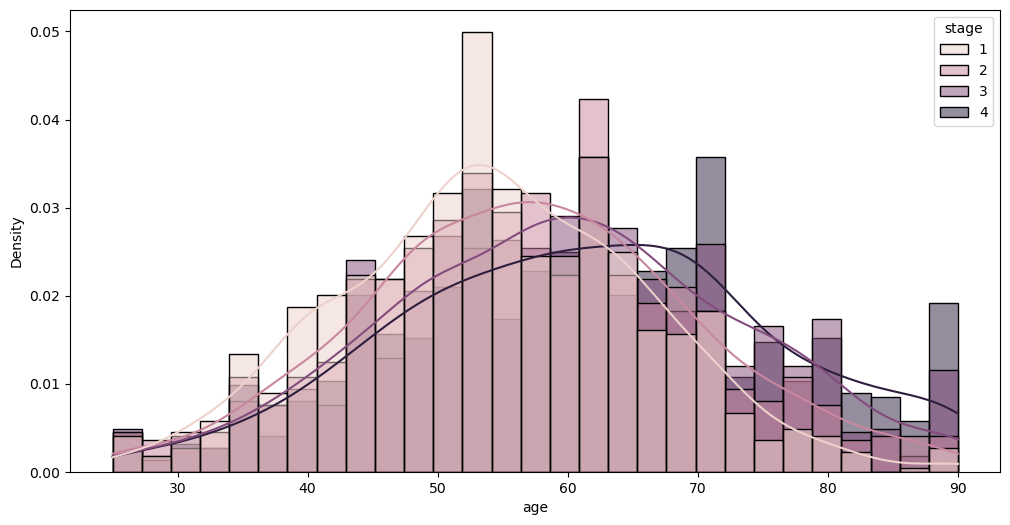

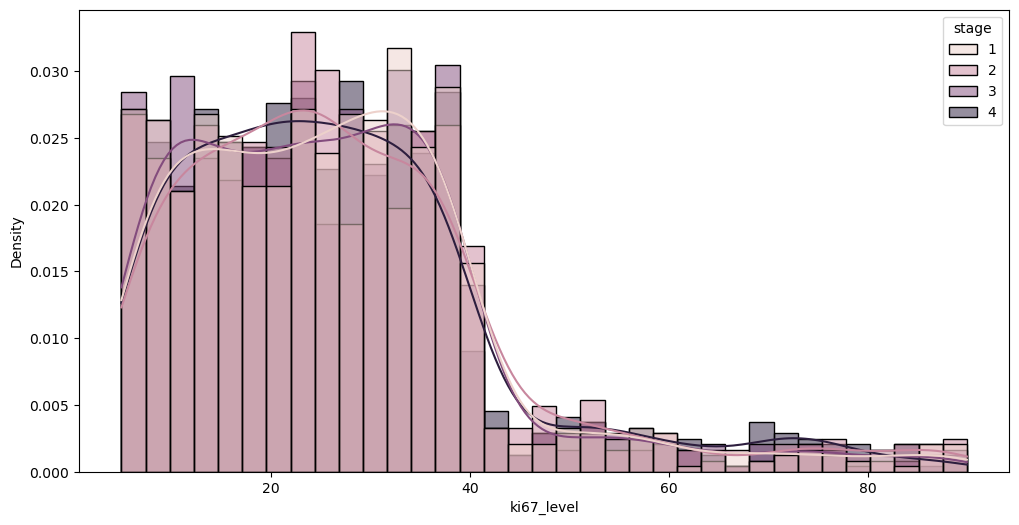

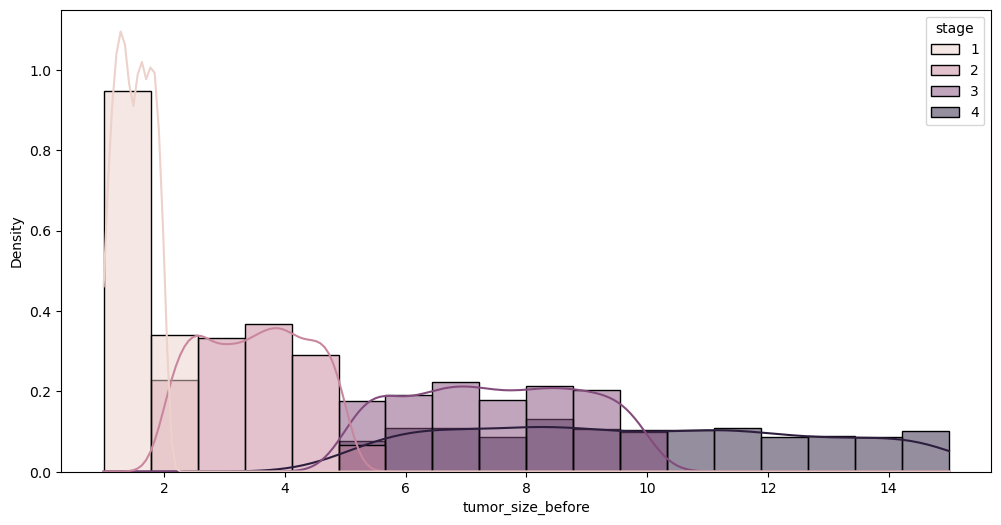

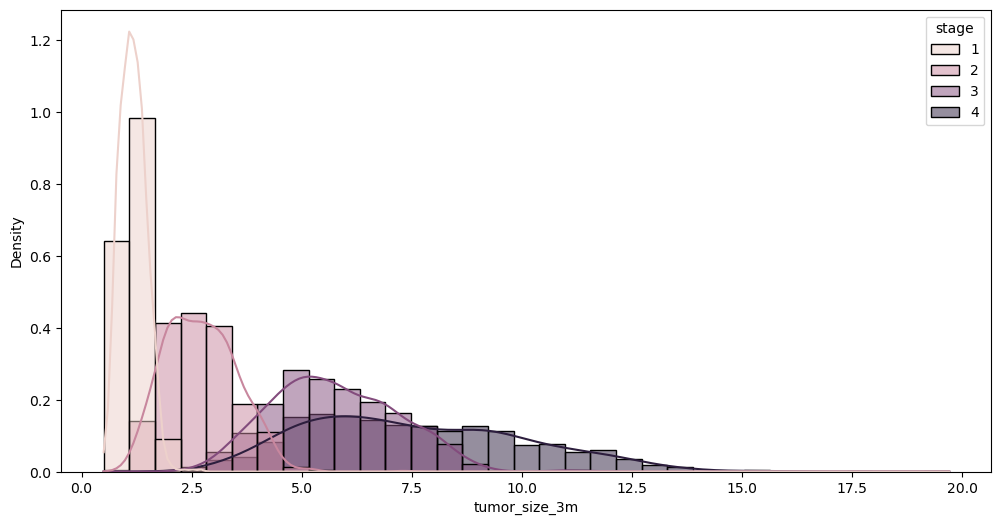

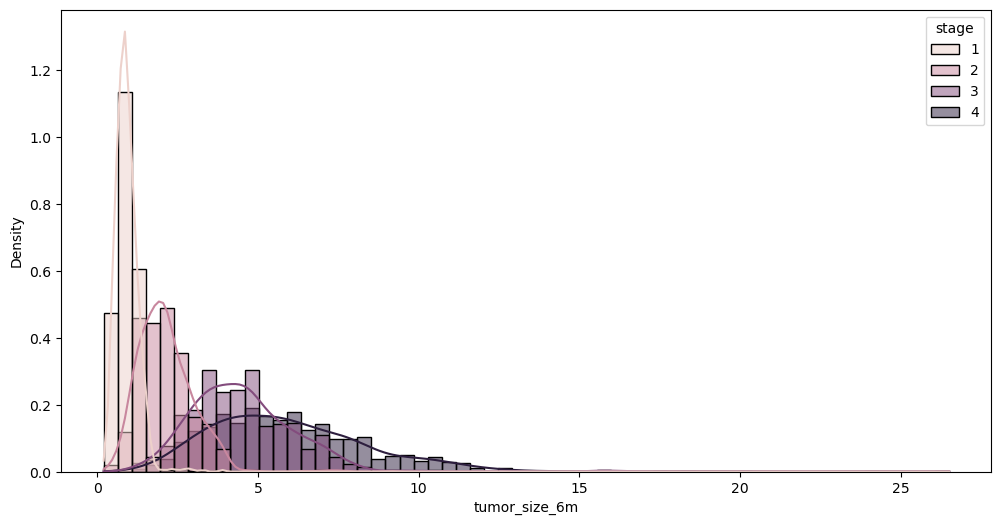

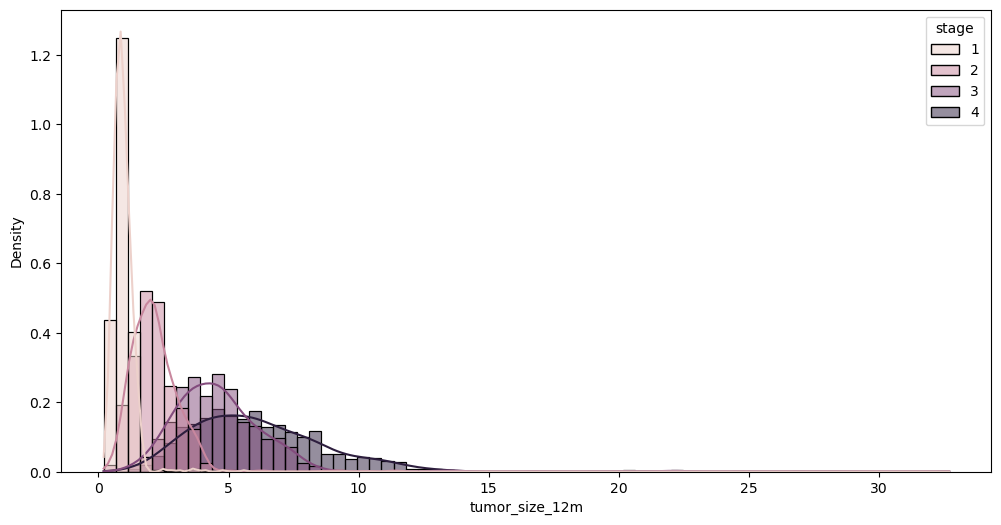

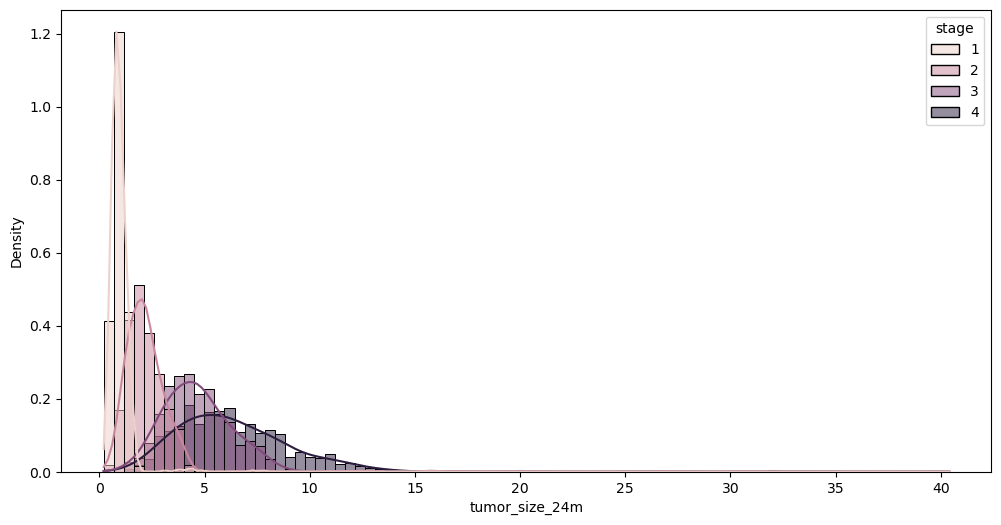

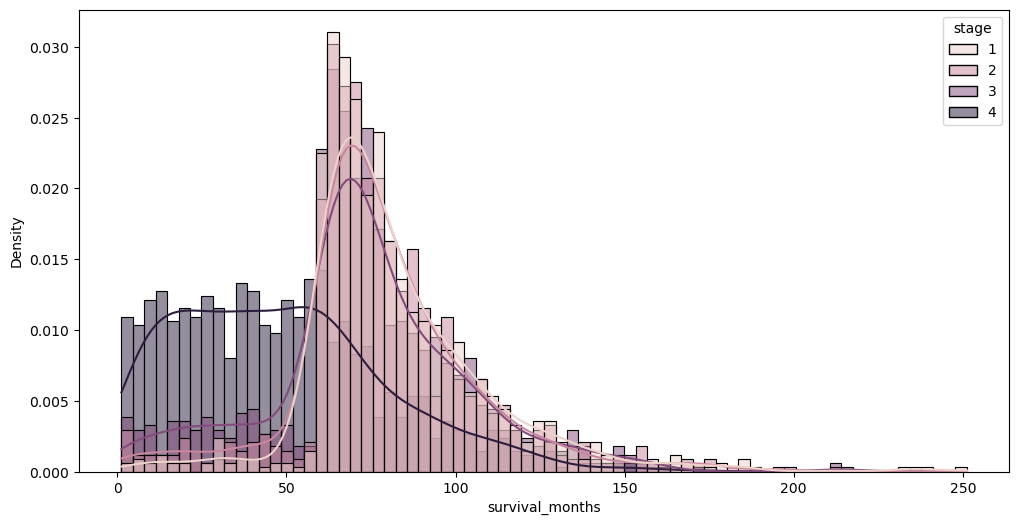

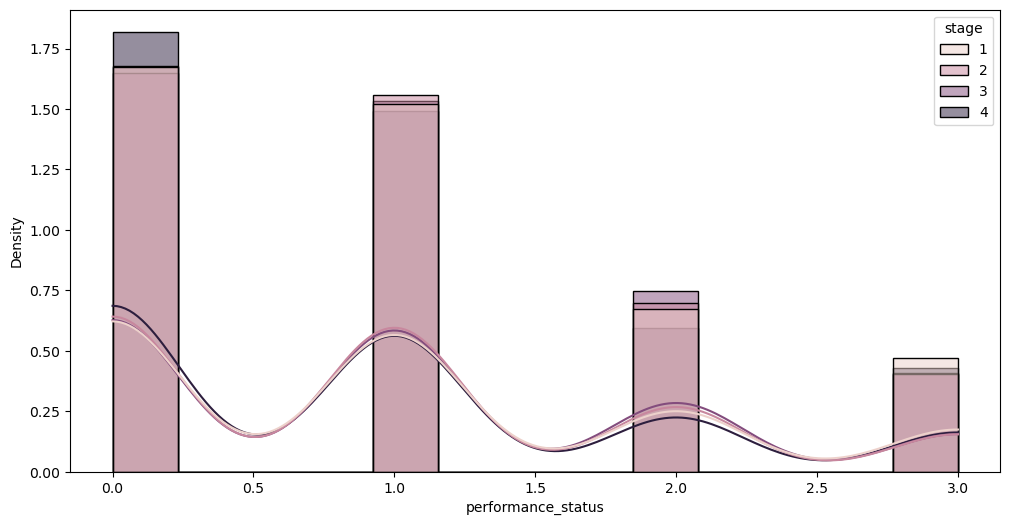

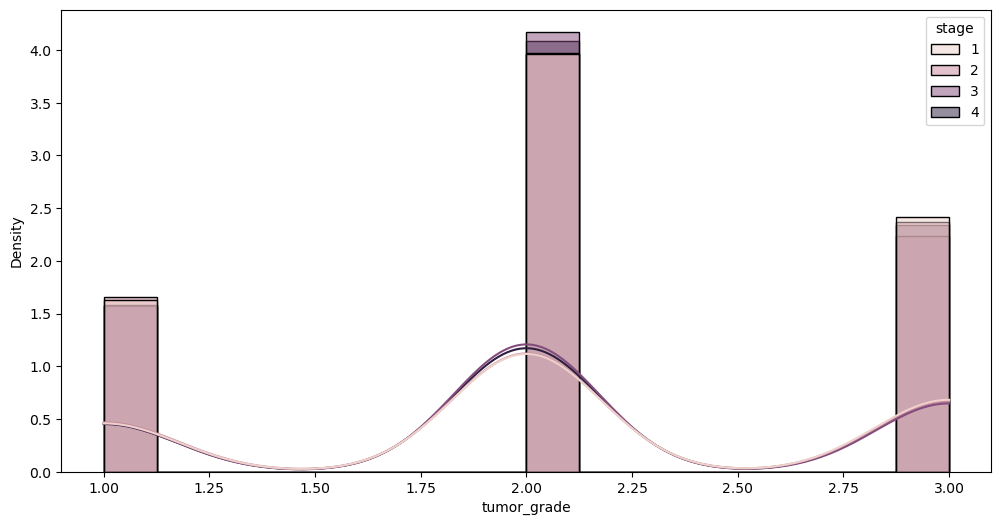

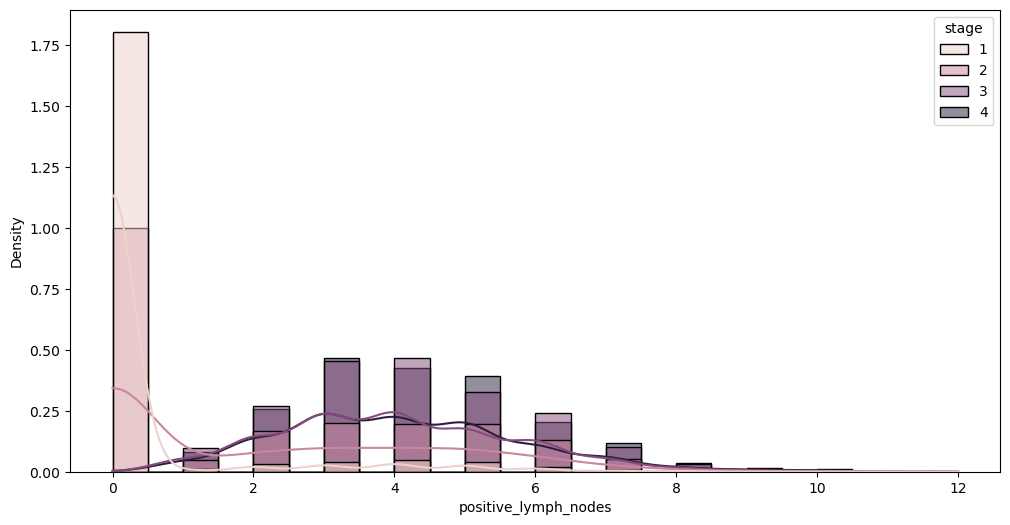

In [155]:
for i in numeric_column[1:]:
    plt.figure(figsize=(12, 6))    
    sns.histplot(
        data=df,
        x=i,
        hue="stage",
        kde=True,
        stat='density',
        common_norm=False
    )
    plt.show()


In [156]:
tumor_size = [
    "tumor_size_before",
    "tumor_size_3m",
    "tumor_size_6m",
    "tumor_size_12m",
    "tumor_size_24m"
]

tumor_df = df[tumor_size]

In [157]:
tumor_df.head()

,tumor_size_before,tumor_size_3m,tumor_size_6m,tumor_size_12m,tumor_size_24m
0,1.4,1.2,1.1,1.1,1.1
1,1.2,0.9,0.8,0.9,0.9
2,1.5,1.2,1.1,1.1,1.1
3,1.1,1.0,0.9,0.9,0.9
4,1.7,1.5,1.4,1.3,1.4


In [158]:
time = np.array([0, 3,6,12,24])

In [159]:
time_0 = df["tumor_size_before"].tolist()
time_3m = df["tumor_size_3m"].tolist()
time_6m = df["tumor_size_6m"].tolist()
time_12m = df["tumor_size_12m"].tolist()
time_24m = df["tumor_size_24m"].tolist()

In [160]:
time_all = np.repeat(time,len(time_0))

In [161]:
tumor_all = time_0 + time_3m + time_6m + time_12m + time_24m

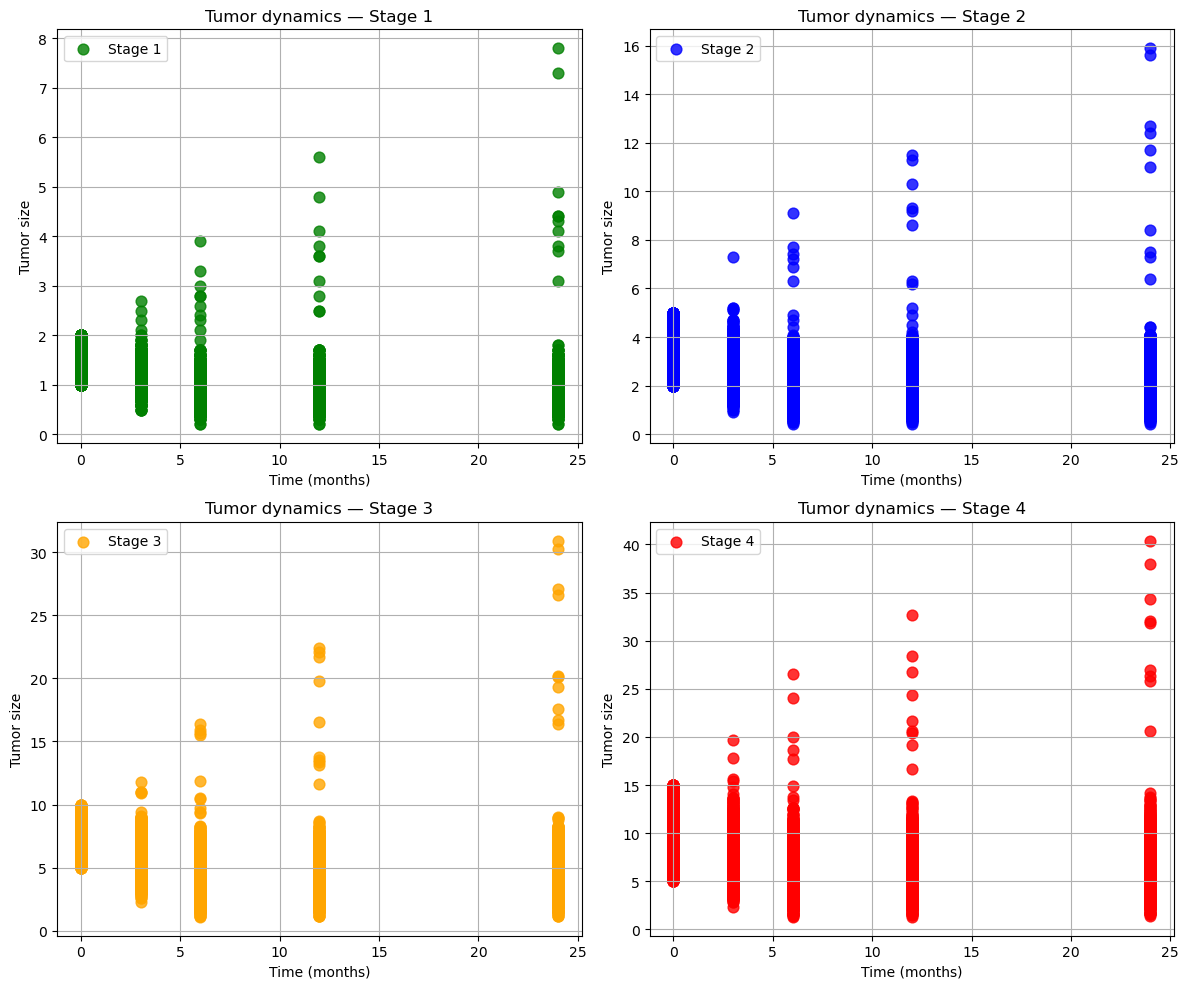

In [162]:
stages = sorted(df["stage"].unique())

colors = {
    1: "green",
    2: "blue",
    3: "orange",
    4: "red"
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, stage in enumerate(stages):
    ax = axes[idx]
    
    mask = df["stage"] == stage
    
    times_raw = np.array([0, 3, 6, 12, 24])
    sizes_raw = [
        df.loc[mask, "tumor_size_before"].dropna().tolist(),
        df.loc[mask, "tumor_size_3m"].dropna().tolist(),
        df.loc[mask, "tumor_size_6m"].dropna().tolist(),
        df.loc[mask, "tumor_size_12m"].dropna().tolist(),
        df.loc[mask, "tumor_size_24m"].dropna().tolist(),
    ]
    

    t_stage = np.repeat(times_raw, [len(s) for s in sizes_raw])

    v_stage = sum(sizes_raw, [])
    
    ax.scatter(
        t_stage,
        v_stage,
        s=60,
        color=colors.get(stage, "black"),
        label=f"Stage {stage}",
        alpha=0.8
    )
    
    ax.set_title(f"Tumor dynamics — Stage {stage}")
    ax.set_xlabel("Time (months)")
    ax.set_ylabel("Tumor size")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


In [163]:
df["subtype"] = None

df.loc[df["molecular_subtype"] == "TNBC", "subtype"] = "TNBC"

df.loc[df["molecular_subtype"].isin(["HR-HER2+", "HR+HER2+"]), 
       "subtype"] = "HER2+"

df.loc[df["molecular_subtype"] == "HR+HER2-", 
       "subtype"] = "HR+"


In [164]:
df_TNBC = df[df["molecular_subtype"] == "TNBC"]
df_HER2 = df[df["molecular_subtype"] == "HER2+"]
df_HR   = df[df["molecular_subtype"] == "HR+"]

In [165]:
df["subtype"].value_counts()

subtype
HR+      2827
HER2+     792
TNBC      381
Name: count, dtype: int64

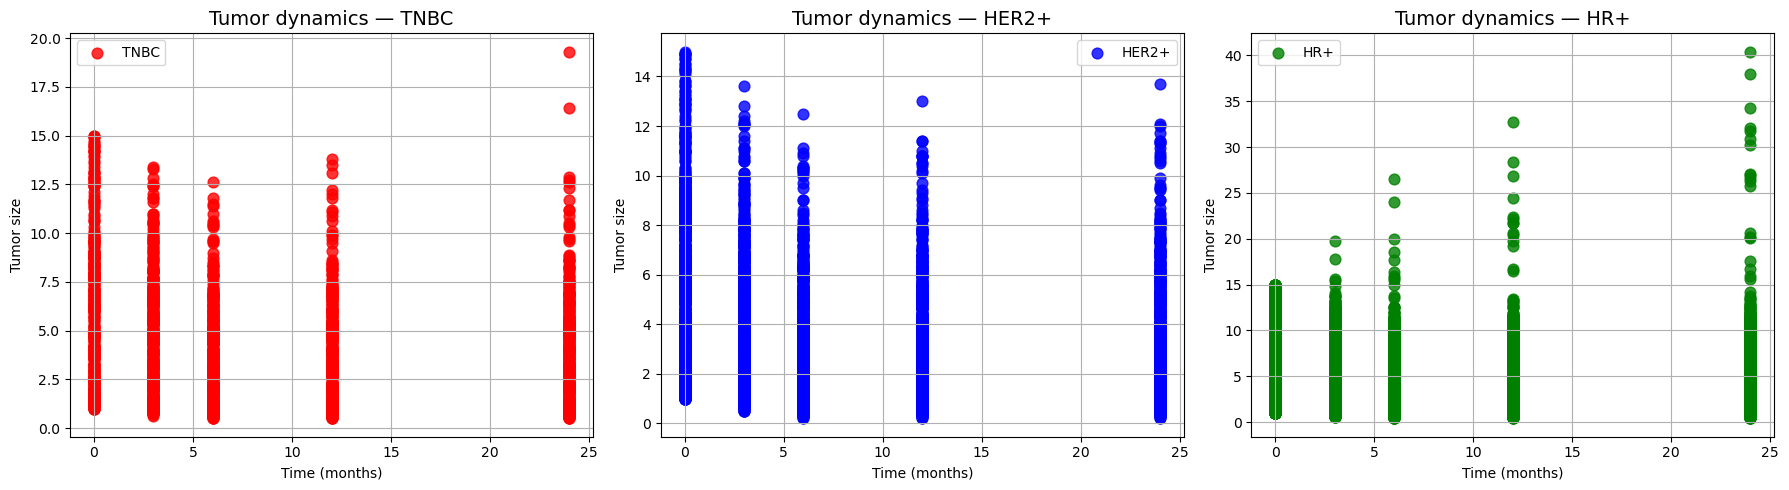

In [166]:
subtypes = ["TNBC", "HER2+", "HR+"]

colors = {
    "TNBC": "red",
    "HER2+": "blue",
    "HR+": "green"
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes = axes.flatten()

for idx, subtype in enumerate(subtypes):
    ax = axes[idx]
    
    mask = df["subtype"] == subtype
    
    times_raw = np.array([0, 3, 6, 12, 24])
    
    sizes_raw = [
        df.loc[mask, "tumor_size_before"].dropna().tolist(),
        df.loc[mask, "tumor_size_3m"].dropna().tolist(),
        df.loc[mask, "tumor_size_6m"].dropna().tolist(),
        df.loc[mask, "tumor_size_12m"].dropna().tolist(),
        df.loc[mask, "tumor_size_24m"].dropna().tolist(),
    ]
    
    t_sub = np.repeat(times_raw, [len(s) for s in sizes_raw])
    
    v_sub = sum(sizes_raw, [])
    
    ax.scatter(
        t_sub,
        v_sub,
        s=60,
        color=colors[subtype],
        label=f"{subtype}",
        alpha=0.8
    )
    
    ax.set_title(f"Tumor dynamics — {subtype}", fontsize=14)
    ax.set_xlabel("Time (months)")
    ax.set_ylabel("Tumor size")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


In [167]:
df_growth_TNBC = df[(df["treatment"] == "no_treatment") & (df["subtype"] == "TNBC")]

In [168]:
df_growth_HER2 = df[(df["treatment"] == "no_treatment") & (df["subtype"] == "HER2+")]

In [169]:
V0_mean  = df_growth_TNBC["tumor_size_before"].mean()
V3_mean  = df_growth_TNBC["tumor_size_3m"].mean()
V6_mean  = df_growth_TNBC["tumor_size_6m"].mean()
V12_mean = df_growth_TNBC["tumor_size_12m"].mean()
V24_mean = df_growth_TNBC["tumor_size_24m"].mean()

In [170]:
t = np.array([0,3,6,12,24])
V_avg = np.array([V0_mean, V3_mean, V6_mean, V12_mean, V24_mean])

In [171]:
TIME_POINTS_MONTHS = np.array([0, 3, 6, 12, 24])


T_cycle_dict = {
"HR+": 3.0,
"HER2+": 2.0,
"TNBC": 1.0,
}


params_pop = {
"HR+": {
"d": 0.01, 
"k_clear": 0.001,
"K": 800.0, 
"f_N0": 0.2
},
"HER2+": {
"d": 0.012,
"k_clear": 0.001,
"K": 700.0,
"f_N0": 0.25,
},
"TNBC": {
"d": 0.015,
"k_clear": 0.0015,
"K": 600.0,
"f_N0": 0.3,
},
}

In [172]:
def r_from_ki67(ki67_fraction: float, T_cycle_days: float) -> float:
    return (np.log(2) / T_cycle_days) * ki67_fraction

In [173]:
PK_PD_PARAMS = {
    "docetaxel": {
        "dose_mg_per_m2": 75.0,   # mg/m2
        "schedule": "q3w",
        "CL": 15.0,
        "Q": 10.0,
        "V1": 15.0,
        "V2": 40.0,
        "E_max": 0.35,
        "EC50": 0.5
    },

    "cyclophosphamide": {
        "dose_mg_per_m2": 600.0, 
        "schedule": "q3w",
        "CL": 10.0,
        "Q": 6.0,
        "V1": 20.0,
        "V2": 55.0,
        "E_max": 0.28,
        "EC50": 0.6
    },

    "doxorubicin": {
        "dose_mg_per_m2": 60.0,   # mg/m2
        "schedule": "q3w",
        "CL": 12.0,
        "Q": 8.0,
        "V1": 20.0,
        "V2": 50.0,
        "E_max": 0.40,
        "EC50": 0.4
    },


    "paclitaxel": {
        "dose_mg_per_m2": 80.0, 
        "schedule": "weekly",
        "CL": 20.0,
        "Q": 10.0,
        "V1": 15.0,
        "V2": 35.0,
        "E_max": 0.30,
        "EC50": 0.7
    },


    "trastuzumab_sc": {
        "dose_mg_fixed": 600.0,   # мг
        "schedule": "q3w",
        "CL": 0.5,
        "Q": 0.3,
        "V1": 3.0,
        "V2": 4.0,
        "E_max": 0.15,
        "EC50": 0.2
    },


    "letrozole": {
        "dose_mg_fixed": 2.5,  
        "schedule": "daily",
        "CL": 0.25,
        "Q": 0.0,
        "V1": 100.0,
        "V2": 0.0,
        "E_max": 0.12,
        "EC50": 0.05
    },


    "tamoxifen": {
        "dose_mg_fixed": 20.0,  
        "schedule": "daily",
        "CL": 0.2,
        "Q": 0.0,
        "V1": 120.0,
        "V2": 0.0,
        "E_max": 0.10,
        "EC50": 0.03
    },


    "anastrozole": {
        "dose_mg_fixed": 1.0, 
        "schedule": "daily",
        "CL": 0.15,
        "Q": 0.0,
        "V1": 80.0,
        "V2": 0.0,
        "E_max": 0.12,
        "EC50": 0.04
    },


    "zoledronic_acid": {
        "dose_mg_fixed": 4.0,    
        "schedule": "q6m",
        "CL": 5.0,
        "Q": 2.0,
        "V1": 6.0,
        "V2": 12.0,
        "E_max": 0.05,
        "EC50": 0.3
    },

    "carboplatin": {
    "dose_mg_per_m2":600 ,  
    "schedule": "q3w",
    "CL": 10.0,
    "Q": 5.0,
    "V1": 20.0,
    "V2": 40.0,
    "E_max": 0.25,
    "EC50": 0.5
    }

}


In [174]:

DOSE_INTERVAL_GRID = {

    "doxorubicin": {
        "type": "mg_per_m2",
        "doses": list(range(50, 71, 10)),     
        "intervals": ["q3w", "q2w"],          
    },

    "cyclophosphamide": {
        "type": "mg_per_m2",
        "doses": list(range(500, 701, 50)),    
        "intervals": ["q3w", "q2w"],
    },

    "docetaxel": {
        "type": "mg_per_m2",
        "doses": list(range(60, 101, 10)),    
        "intervals": ["q3w"],
    },

    "paclitaxel": {
        "type": "mg_per_m2",
        "doses": [60, 80, 100, 150, 175],
        "intervals": ["weekly", "q2w"],
    },

    "trastuzumab_sc": {
        "type": "fixed_mg",
        "doses": [600],
        "intervals": ["q3w"],
    },
 
    "letrozole": {
        "type": "fixed_mg",
        "doses": [2.5],
        "intervals": ["daily"],
    },
    "tamoxifen": {
        "type": "fixed_mg",
        "doses": [20],
        "intervals": ["daily"],
    },
    "anastrozole": {
        "type": "fixed_mg",
        "doses": [1.0],
        "intervals": ["daily"],
    },

    "zoledronic_acid": {
        "type": "fixed_mg",
        "doses": [4.0],
        "intervals": ["q6m"],
    },
 
    "carboplatin": {
        "type": "mg_per_m2",
        "doses": list(range(300, 601, 50)),    
        "intervals": ["q3w"],
    },
}


In [175]:
REGIMENS = {

    "TC": {
        "description": "Docetaxel + Cyclophosphamide",
        "drugs": ["docetaxel", "cyclophosphamide"]
    },


    "AC": {
        "description": "Doxorubicin + Cyclophosphamide",
        "drugs": ["doxorubicin", "cyclophosphamide"]
    },

 
    "AC_T": {
        "description": "Doxorubicin + Cyclophosphamide followed by Paclitaxel",
        "phases": [
        {"duration": 84.0, "drugs": ["doxorubicin", "cyclophosphamide"]}, # 4 цикла по 21
        {"duration": 84.0, "drugs": ["paclitaxel"]}, # 12 weekly
        ],
    },


 
    "T_paclitaxel": {
        "description": "Trastuzumab + Paclitaxel",
        "drugs": ["trastuzumab_sc", "paclitaxel"]
    },

  
    "T_mono": {
        "description": "Trastuzumab monotherapy",
        "drugs": ["trastuzumab_sc"]
    },


    "LET": {
        "description": "Letrozole monotherapy",
        "drugs": ["letrozole"]
    },


    "TAM": {
        "description": "Tamoxifen monotherapy",
        "drugs": ["tamoxifen"]
    },

  
    "ANA": {
        "description": "Anastrozole monotherapy",
        "drugs": ["anastrozole"]
    },

   
    "BONE": {
        "description": "Zoledronic acid",
        "drugs": ["zoledronic_acid"]
    },

    "PLATINUM": {
    "description": "Carboplatin",
    "drugs": ["carboplatin"]
    }

}

In [176]:
RECOMMENDED_REGIMENS = {
    
    "HR+": [
        {
            "name": "LET",
            "comment": "Гормонотерапия — тамоксифен/ингибитор ароматазы ± овариальная супрессия"
        },
        {
            "name": "TC",
            "comment": "DC: доцетаксел + циклофосфамид, предпочтительный режим 4–6 циклов"
        },
        {
            "name": "AC",
            "comment": "AC/EC 4 цикла"
        },
        {
            "name": "AC_T",
            "comment": "AC/EC → доцетаксел 4 цикла или паклитаксел weekly 12 раз"
        }
    ],


    "HER2+": [
        {
            "name": "T_paclitaxel",
            "comment": "Таксан + трастузумаб (± пертузумаб) одновременно"
        },
        {
            "name": "T_mono",
            "comment": "Поддерживающая HER2-терапия трастузумабом"
        },
        {
            "name": "AC_T",
            "comment": "AC → таксан → анти-HER2 (антрациклины отдельно от HER2)"
        }
    ],


    "TNBC": [
        {
            "name": "AC",
            "comment": "Антрациклины (AC/EC)"
        },
        {
            "name": "TC",
            "comment": "Доцетаксел + циклофосфамид"
        },
        {
            "name": "AC_T",
            "comment": "AC → таксаны (паклитаксел weekly или доцетаксел)"
        },
        {
            "name": "PLATINUM",
            "comment": "Платина (например, карбоплатин) — рекомендовано при TNBC"
        }
    ]
}


In [177]:
def get_recommended_for_subtype(subtype: str):

    return [item["name"] for item in RECOMMENDED_REGIMENS.get(subtype, [])]

In [178]:
def E_of_C(C, E_max, EC50):
    return E_max * C / (C + EC50 + 1e-12)



In [179]:
def pk_input_bolus(t, dose_time=0.0, dose_amount=100.0):
    if abs(t - dose_time) < 1e-6:
        return dose_amount 
    return 0.0

def pk_input_infusion(t, start=0.0, end=1.0, rate=50.0):
    if start <= t <= end:
        return rate 
    return 0.0

def pk_input_cycles(t, cycle_len=21, dose_amount=100.0):
    if abs(t % cycle_len) < 1e-6:
        return dose_amount
    return 0.0

In [180]:
def pk_one_comp_ode(t, y, CL, V1, input_func=None):
    A = y[0]
    I = input_func(t) if input_func else 0.0
    dA_dt = -(CL / V1) * A + I
    return [dA_dt]

In [181]:
def pk_two_comp_ode(t, y, CL, Q, V1, V2, input_func=None):

    A1, A2 = y
    I = input_func(t) if input_func else 0.0


    dA1dt = -(CL / V1) * A1 - (Q / V1) * A1 + (Q / V2) * A2 + I
    dA2dt = (Q / V1) * A1 - (Q / V2) * A2
    return [dA1dt, dA2dt]

def simulate_pk_two_comp(CL, Q, V1, V2,
    y0, t_end, n_points=2000,
    input_func=None):

    t_eval = np.linspace(0.0, t_end, n_points)


    sol = solve_ivp(
    lambda tt, yy: pk_two_comp_ode(tt, yy, CL, Q, V1, V2, input_func),
    [0.0, t_end],
    y0,
    t_eval=t_eval,
    )


    A1 = sol.y[0]
    C1 = A1 / V1


    C_interp = interp1d(t_eval, C1, fill_value="extrapolate")
    return C_interp


In [182]:
def build_single_drug_pkpd(
    drug_name: str,
    t_end: float = 365.0,
    bsa: float = 1.7,
    dose_abs_override: float | None = None,
    schedule_override: str | None = None,
):

    if drug_name not in PK_PD_PARAMS:
        raise ValueError(f"Препарат {drug_name} отсутствует в PK_PD_PARAMS")

    p = PK_PD_PARAMS[drug_name]
    CL, Q, V1, V2 = p["CL"], p["Q"], p["V1"], p["V2"]

    is_one_comp = (p["Q"] == 0 or p["V2"] == 0)


    E_max, EC50 = p["E_max"], p["EC50"]

    schedule = schedule_override if schedule_override is not None else p["schedule"]


    if dose_abs_override is not None:
        dose_abs = dose_abs_override
    else:
        if "dose_mg_per_m2" in p:
            dose_abs = p["dose_mg_per_m2"] * bsa
        elif "dose_mg_fixed" in p:
            dose_abs = p["dose_mg_fixed"]
        else:
            raise ValueError(f"Не найдена доза для препарата {drug_name}")


    if schedule == "q3w":
        cycle = 21.0
        input_func = lambda tt, d=dose_abs, c=cycle: pk_input_cycles(tt, c, d)
        y0 = [0.0, 0.0]
    elif schedule == "q2w":
        cycle = 14.0
        input_func = lambda tt, d=dose_abs, c=cycle: pk_input_cycles(tt, c, d)
        y0 = [0.0, 0.0]
    elif schedule == "weekly":
        cycle = 7.0
        input_func = lambda tt, d=dose_abs, c=cycle: pk_input_cycles(tt, c, d)
        y0 = [0.0, 0.0]
    elif schedule == "daily":
        cycle = 1.0
        input_func = lambda tt, d=dose_abs, c=cycle: pk_input_cycles(tt, c, d)
        y0 = [0.0, 0.0]
    elif schedule == "q6m":
        cycle = 180.0
        input_func = lambda tt, d=dose_abs, c=cycle: pk_input_cycles(tt, c, d)
        y0 = [0.0, 0.0]
    else:

        input_func = None
        y0 = [dose_abs, 0.0]


    if is_one_comp:

        def pk_ode(tt, yy):
            return pk_one_comp_ode(tt, yy, CL, V1, input_func)

        t_eval = np.linspace(0, t_end, 2000)
        sol = solve_ivp(pk_ode, [0, t_end], [0.0], t_eval=t_eval)
        C = sol.y[0] / V1
        C_func = interp1d(t_eval, C, fill_value="extrapolate")

    else:

        C_func = simulate_pk_two_comp(
            CL, Q, V1, V2,
            y0=y0,
            t_end=t_end,
            n_points=2000,
            input_func=input_func
        )

    return C_func, E_max, EC50



In [183]:
def make_regimen_drug_effect(regimen_name: str, t_end: float = 365.0, bsa: float = 1.7):

    reg = REGIMENS[regimen_name]

    if "phases" not in reg:
        drug_names = reg["drugs"]
        pk_list = []  # список (C_func, E_max, EC50)

        for dname in drug_names:
            C_func, E_max, EC50 = build_single_drug_pkpd(dname, t_end=t_end, bsa=bsa)
            pk_list.append((C_func, E_max, EC50))

        def drug_effect(t: float) -> float:
            total = 0.0
            for C_func, E_max, EC50 in pk_list:
                C = float(C_func(t))
                total += E_of_C(C, E_max, EC50)
            return total

        return drug_effect


    phases = reg["phases"]

    pk_list = [] 

    t_shift = 0.0
    for ph in phases:
        duration = ph["duration"]
        drugs = ph["drugs"]

        for dname in drugs:

            C_phase, E_max, EC50 = build_single_drug_pkpd(
                dname, t_end=duration, bsa=bsa
            )

            def make_shifted(C_local, shift, dur):

                def C_global(t):
                    tau = t - shift
                    if tau < 0:
                        return 0.0

                    return float(C_local(max(tau, 0.0)))

                return C_global

            C_shifted = make_shifted(C_phase, t_shift, duration)
            pk_list.append((C_shifted, E_max, EC50))

        t_shift += duration

    def drug_effect(t: float) -> float:
        total = 0.0
        for C_func, E_max, EC50 in pk_list:
            C = C_func(t)
            total += E_of_C(C, E_max, EC50)
        return total

    return drug_effect



In [184]:
def get_resistance_params(row_like,
                          manual_mutation_rate=None,
                          manual_resistance_strength=None):

    if manual_mutation_rate is not None and manual_resistance_strength is not None:
        return manual_mutation_rate, manual_resistance_strength

    response = None
    if hasattr(row_like, "get"):
        response = row_like.get("treatment_response", None)
    else:
        try:
            response = row_like["treatment_response"]
        except Exception:
            response = None

    if response is None:
        return None

    response = str(response).upper().strip()

    if response == "PD":
        return 0.02, 0.2
    elif response == "SD":
        return 0.01, 0.5
    elif response in ["PR", "PARTIAL RESPONSE"]:
        return 0.007, 0.7
    elif response in ["CR", "COMPLETE RESPONSE"]:
        return 0.005, 0.8
    else:
        return 0.01, 0.5

In [185]:
def tumor_ode_no_resistance(t, y,
                            r, K, d_base, k_clear,
                            drug_effect_func):

    U, N = y
    drug = drug_effect_func(t) if drug_effect_func is not None else 0.0
    d_eff = d_base + drug

    dUdt = r * U * (1 - (U + N) / K) - d_eff * U
    dNdt = d_eff * U - k_clear * N
    return [dUdt, dNdt]

In [186]:
def tumor_ode_with_resistance(t, y,
                              r, K, d_base, k_clear,
                              drug_effect_func,
                              mutation_rate, resistance_strength):

    Ns, Nr, N = y
    drug = drug_effect_func(t) if drug_effect_func is not None else 0.0

    death_s = (d_base + drug) * Ns
    death_r = (d_base + drug * resistance_strength) * Nr

    mut = mutation_rate * Ns
    U_total = Ns + Nr

    growth_s = r * Ns * (1 - (U_total + N) / K)
    growth_r = r * Nr * (1 - (U_total + N) / K)

    dNsdt = growth_s - death_s - mut
    dNrdt = growth_r - death_r + mut
    dNdt = death_s + death_r - k_clear * N

    return [dNsdt, dNrdt, dNdt]

In [187]:
def simulate_patient(subtype: str,
                     ki67_percent: float,
                     V0: float,
                     regimen_name: str | None = None,
                     t_end: float = 365.0,
                     use_resistance: bool = False,
                     mutation_rate: float | None = None,
                     resistance_strength: float | None = None,
                     row_like_for_resistance=None,
                     bsa: float = 1.7,
                     drug_effect_override=None):


    pop = params_pop[subtype]
    T_cycle = T_cycle_dict[subtype]

    d_base = pop["d"]
    k_clear = pop["k_clear"]
    K = pop["K"]
    f_N0 = pop["f_N0"]

    r = r_from_ki67(ki67_percent / 100.0, T_cycle)

    if drug_effect_override is not None:
        drug_effect_func = drug_effect_override
    elif regimen_name is not None:
        drug_effect_func = make_regimen_drug_effect(
            regimen_name, t_end=t_end, bsa=bsa
        )
    else:
        drug_effect_func = lambda t: 0.0

    t_eval = np.linspace(0.0, t_end, 600)


    if not use_resistance:
        U0 = (1.0 - f_N0) * V0
        N0 = f_N0 * V0
        y0 = [U0, N0]

        sol = solve_ivp(
            lambda tt, yy: tumor_ode_no_resistance(
                tt, yy,
                r=r, K=K,
                d_base=d_base, k_clear=k_clear,
                drug_effect_func=drug_effect_func,
            ),
            [0.0, t_end],
            y0,
            t_eval=t_eval,
        )

        U, N = sol.y
        V = U + N
        return t_eval, V, U, N


    if mutation_rate is None or resistance_strength is None:
        if row_like_for_resistance is not None:
            params_res = get_resistance_params(row_like_for_resistance)
            if params_res is not None:
                mutation_rate, resistance_strength = params_res
            else:
                return simulate_patient(
                    subtype, ki67_percent, V0,
                    regimen_name=regimen_name,
                    t_end=t_end,
                    use_resistance=False,
                    bsa=bsa,
                    drug_effect_override=drug_effect_override
                )
        else:
            return simulate_patient(
                subtype, ki67_percent, V0,
                regimen_name=regimen_name,
                t_end=t_end,
                use_resistance=False,
                bsa=bsa,
                drug_effect_override=drug_effect_override
            )

    U0 = (1.0 - f_N0) * V0
    Ns0 = U0 * 0.95
    Nr0 = U0 * 0.05
    N0 = f_N0 * V0
    y0 = [Ns0, Nr0, N0]

    sol = solve_ivp(
        lambda tt, yy: tumor_ode_with_resistance(
            tt, yy,
            r=r, K=K,
            d_base=d_base, k_clear=k_clear,
            drug_effect_func=drug_effect_func,
            mutation_rate=mutation_rate,
            resistance_strength=resistance_strength,
        ),
        [0.0, t_end],
        y0,
        t_eval=t_eval,
    )

    Ns, Nr, N = sol.y
    V = Ns + Nr + N
    return t_eval, V, Ns, Nr, N


In [188]:
def get_pk_profiles(regimen_name: str, t_end: float = 365.0, bsa: float = 1.7):

    reg = REGIMENS[regimen_name]
    profiles: dict[str, dict] = {}

    if "phases" not in reg:
        drugs = reg["drugs"]
        for d in drugs:
            C_func, E_max, EC50 = build_single_drug_pkpd(d, t_end=t_end, bsa=bsa)
            t = np.linspace(0, t_end, 800)
            C = np.array([float(C_func(tt)) for tt in t])
            profiles[d] = {"t": t, "C": C, "E_max": E_max, "EC50": EC50}
        return profiles


    t_global = np.linspace(0.0, t_end, 800)
    t_shift = 0.0

    for phase in reg["phases"]:
        duration = phase["duration"]
        drugs = phase["drugs"]

        for d in drugs:
            C_phase, E_max, EC50 = build_single_drug_pkpd(d, t_end=duration, bsa=bsa)

            C_global = []
            for tt in t_global:
                tau = tt - t_shift
                if tau < 0:
                    C_global.append(0.0)
                else:
                    C_global.append(float(C_phase(max(tau, 0.0))))

            C_global = np.array(C_global)

            if d not in profiles:
                profiles[d] = {
                    "t": t_global,
                    "C": np.zeros_like(t_global),
                    "E_max": E_max,
                    "EC50": EC50,
                }

            profiles[d]["C"] += C_global

        t_shift += duration

    return profiles

In [189]:
def compute_pd_effect(pk_profiles: dict):

    any_prof = next(iter(pk_profiles.values()))
    t = any_prof["t"]

    total_effect = np.zeros_like(t)
    details = {}

    for drug, prof in pk_profiles.items():
        C = prof["C"]
        E = E_of_C(C, prof["E_max"], prof["EC50"])
        details[drug] = E
        total_effect += E

    return t, total_effect, details

In [190]:
def plot_full_simulation(subtype: str,
                         ki67: float,
                         V0: float,
                         regimen: str,
                         t_end: float = 365.0,
                         use_resistance: bool = False,
                         row=None):

    print("Симуляция опухоли")
    if not use_resistance:
        t, V, U, N = simulate_patient(
            subtype=subtype,
            ki67_percent=ki67,
            V0=V0,
            regimen_name=regimen,
            t_end=t_end,
            use_resistance=False,
        )
        Ns = Nr = None
    else:
        t, V, Ns, Nr, N = simulate_patient(
            subtype=subtype,
            ki67_percent=ki67,
            V0=V0,
            regimen_name=regimen,
            t_end=t_end,
            use_resistance=True,
            row_like_for_resistance=row,
        )

    print("Расчёт PK")
    pk = get_pk_profiles(regimen, t_end=t_end)

    print("Расчёт PD")
    t_pd, total_effect, pd_details = compute_pd_effect(pk)

    fig, axs = plt.subplots(3, 1, figsize=(10, 16))

    axs[0].plot(t, V, label="V(t) общий", linewidth=2)
    if not use_resistance:
        axs[0].plot(t, U, "--", label="U(t) живые")
        axs[0].plot(t, N, "--", label="N(t) некроз")
    else:
        axs[0].plot(t, Ns, "--", label="Ns(t) чувствительные")
        axs[0].plot(t, Nr, "--", label="Nr(t) резистентные")
        axs[0].plot(t, N, "--", label="N(t) некроз")

    axs[0].set_title(f"Tumor — {subtype}, regimen={regimen}")
    axs[0].set_ylabel("Объём (условн. ед.)")
    axs[0].legend()
    axs[0].grid(True)


    for drug, prof in pk.items():
        axs[1].plot(prof["t"], prof["C"], label=f"{drug}")
    axs[1].set_title("PK: C(t) препаратов")
    axs[1].set_ylabel("C(t)")
    axs[1].legend()
    axs[1].grid(True)


    axs[2].plot(t_pd, total_effect, label="Суммарный эффект", linewidth=2)
    for drug, E in pd_details.items():
        axs[2].plot(t_pd, E, "--", label=f"{drug} (E)")

    axs[2].set_title("PD: цитотоксический эффект")
    axs[2].set_ylabel("Effect (условн. ед.)")
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

In [191]:
def choose_optimal_regimen(subtype: str, ki67: float, stage: int, lymph_nodes_pos: int):
    if subtype == "TNBC":
        if stage >= 4:
            return "PLATINUM"
        if ki67 > 40:
            return "AC_T"
        else:
            if stage == 1:
                return "TC"
            else:
                return "AC_T"


    if subtype == "HER2+":
        if stage == 1:
            return "T_paclitaxel"
        if stage in [2, 3]:
            return "AC_T"
        if stage >= 4:
            return "T_mono" 
        return "T_paclitaxel"

    if subtype == "HR+":
        if ki67 < 15:
            return "LET"
        elif 15 <= ki67 <= 30:
            if stage >= 2:
                return "TC"
            return "LET"
        else:  
            if lymph_nodes_pos > 0:
                return "AC_T"
            return "TC"

    return None

In [192]:
def select_regimen_for_patient(subtype: str,
                               ki67: float,
                               stage: int,
                               lymph_nodes_pos: int,
                               doctor_choice: str | None = None,
                               drug_choice: str | None = None):


    recommended_regimens = get_recommended_for_subtype(subtype)
    available_drugs = list(PK_PD_PARAMS.keys())


    if drug_choice is not None:
        if drug_choice in available_drugs:
            print(f"Врач выбрал препарат {drug_choice} — создаём моно-схему.")

            REGIMENS[f"mono_{drug_choice}"] = {
                "description": f"Monotherapy: {drug_choice}",
                "drugs": [drug_choice]
            }
            return f"mono_{drug_choice}"
        else:
            print("Препарат не найден в базе — проигнорировано.")


    if doctor_choice is not None:
        if doctor_choice in recommended_regimens:
            return doctor_choice
        else:
            print(" Схема не в рекомендациях, но принимаем.")
            return doctor_choice

    auto = choose_optimal_regimen(subtype, ki67, stage, lymph_nodes_pos)
    return auto


In [193]:
REGIMEN_DURATION = {
    "AC": 84,          # 4 цикла × 21 день
    "TC": 84,          # 4 цикла
    "PLATINUM": 84,    # 4 цикла
    "T_paclitaxel": 84,  # weekly 12 раз
    "AC_T": 168,       # 84 дней AC + 84 дней T
    "T_mono": 365,     # год терапии
    "LET": 365,
    "TAM": 365,
    "ANA": 365,
    "BONE": 365,       # условно
}

def get_default_t_end(regimen_name):
    return REGIMEN_DURATION.get(regimen_name, 365)


In [194]:
TOXICITY_LIMITS = {

    "doxorubicin": {
        "max_cumulative_mg_per_m2": 500  
    },
    "epirubicin": {
        "max_cumulative_mg_per_m2": 900
    },
    "carboplatin": {

        "max_cumulative_mg_per_m2": 800
    },
    # Нет известных строгих ограничений
    "docetaxel": None,
    "paclitaxel": None,
    "cyclophosphamide": None,
    "letrozole": None,
    "tamoxifen": None,
    "anastrozole": None,
    "trastuzumab_sc": None,
    "zoledronic_acid": None,
}


In [195]:
PROTOCOL_MAX_CYCLES = {
    "doxorubicin": 6,
    "cyclophosphamide": 6,
    "docetaxel": 6,
    "paclitaxel": 12,
    "carboplatin": 6,
}

def check_toxicity(drug_name, dose_abs, interval, t_end, bsa):

    limits = TOXICITY_LIMITS.get(drug_name)
    if limits is None:
        return True

    max_mg_per_m2 = limits.get("max_cumulative_mg_per_m2")
    if max_mg_per_m2 is None:
        return True

    # расчёт количества введений
    if interval == "q3w":
        n = int(t_end // 21)
    elif interval == "q2w":
        n = int(t_end // 14)
    elif interval == "weekly":
        n = int(t_end // 7)
    elif interval == "daily":
        n = int(t_end)
    elif interval == "q6m":
        n = int(t_end // 180)
    else:
        n = 1


    n = min(n, PROTOCOL_MAX_CYCLES.get(drug_name, n))


    dose_mg_per_m2 = dose_abs / bsa
    cumulative_dose = dose_mg_per_m2 * n

    return cumulative_dose <= max_mg_per_m2


In [196]:
def count_cycles(interval, t_end, drug_name):
    if interval == "q3w":
        n = int(t_end // 21)
    elif interval == "q2w":
        n = int(t_end // 14)
    elif interval == "weekly":
        n = int(t_end // 7)
    elif interval == "daily":
        n = int(t_end)
    elif interval == "q6m":
        n = int(t_end // 180)
    else:
        n = 1


    n = min(n, PROTOCOL_MAX_CYCLES.get(drug_name, n))

    return n


In [197]:
def grid_search_single_drug(subtype: str,
                            ki67: float,
                            V0: float,
                            drug_name: str,
                            t_end: float | None = None,
                            bsa: float = 1.7,
                            use_resistance: bool = False,
                            row_like_for_resistance=None,
                            objective: str = "min_final_volume",
                            doctor_fixed_interval: str | None = None):

    if t_end is None:
        t_end = 365 

    grid = DOSE_INTERVAL_GRID[drug_name]
    doses = grid["doses"]
    dose_type = grid["type"]

    intervals = [doctor_fixed_interval] if doctor_fixed_interval else grid["intervals"]

    best_score = np.inf
    best_result = None

    for interval in intervals:

        n_cycles = count_cycles(interval, t_end, drug_name)
        if n_cycles == 0:
            continue

      
        dt = {"q3w":21, "q2w":14, "weekly":7, "daily":1, "q6m":180}.get(interval, 21)
        t_local_end = n_cycles * dt

        for dose in doses:

            dose_abs = dose * bsa if dose_type=="mg_per_m2" else dose

   
            if not check_toxicity(drug_name, dose_abs, interval, t_local_end, bsa):
                continue

   
            C_func, E_max, EC50 = build_single_drug_pkpd(
                drug_name,
                t_end=t_local_end,
                bsa=bsa,
                dose_abs_override=dose_abs,
                schedule_override=interval
            )

            def drug_eff(t):
                return E_of_C(C_func(t), E_max, EC50)

            t, *rest = simulate_patient(
                subtype=subtype,
                ki67_percent=ki67,
                V0=V0,
                regimen_name=None,
                drug_effect_override=drug_eff,
                t_end=t_local_end,
                use_resistance=use_resistance,
                row_like_for_resistance=row_like_for_resistance,
                bsa=bsa
            )

            V = rest[0]
            score = V[-1] if objective=="min_final_volume" else np.min(V)

            if score < best_score:
                best_score = score
                best_result = {
                    "drug": drug_name,
                    "interval": interval,
                    "dose": dose,
                    "dose_abs": dose_abs,
                    "t": t,
                    "V": V,
                    "cycles": n_cycles
                }

    return best_result


In [198]:
NON_PHASE_REGIMENS = {
    "TC", "AC", "T_paclitaxel", "LET", "TAM", "ANA", "BONE", "PLATINUM"
}

In [199]:
def grid_search_regimen(
        subtype: str,
        ki67: float,
        V0: float,
        regimen_name: str,
        t_end: float = 365.0,
        bsa: float = 1.7,
        use_resistance: bool = False,
        row_like_for_resistance=None,
        objective: str = "min_final_volume"
):

    if regimen_name not in REGIMENS:
        raise ValueError(f"Схема {regimen_name} не найдена")

    reg = REGIMENS[regimen_name]

    if "phases" in reg:
        raise ValueError("Фазные схемы (AC→T) не оптимизируются через этот grid search.")

    drugs = reg["drugs"]

    options_per_drug = []
    for d in drugs:
        if d not in DOSE_INTERVAL_GRID:
            raise ValueError(f"Нет сетки доз/интервалов для {d}")

        grid = DOSE_INTERVAL_GRID[d]
        dose_type = grid["type"]

        dose_abs_list = []
        for dose in grid["doses"]:
            if dose_type == "mg_per_m2":
                dose_abs_list.append(dose * bsa)
            else:
                dose_abs_list.append(dose)

        options = []
        for interval in grid["intervals"]:
            for dose_abs in dose_abs_list:
                options.append((interval, dose_abs))

        options_per_drug.append((d, options))


    best_score = np.inf
    best_result = None

    def backtrack(idx, current_choices):
        nonlocal best_score, best_result

  
        if idx == len(options_per_drug):
 
            pk_cache = []

            for drug_name, interval, dose_abs in current_choices:
                C_func, E_max, EC50 = build_single_drug_pkpd(
                    drug_name,
                    t_end=t_end,
                    bsa=bsa,
                    dose_abs_override=dose_abs,
                    schedule_override=interval
                )
                pk_cache.append((C_func, E_max, EC50))

  
            def drug_eff(t):
                total = 0.0
                for C_func, E_max, EC50 in pk_cache:
                    total += E_of_C(C_func(t), E_max, EC50)
                return total

            t_vec, *rest = simulate_patient(
                subtype=subtype,
                ki67_percent=ki67,
                V0=V0,
                regimen_name=None,
                drug_effect_override=drug_eff,
                t_end=t_end,
                use_resistance=use_resistance,
                row_like_for_resistance=row_like_for_resistance,
                bsa=bsa
            )

            V = rest[0]

            score = V[-1] if objective == "min_final_volume" else np.min(V)

            if score < best_score:
                best_score = score
                best_result = {
                    "regimen": regimen_name,
                    "choices": current_choices.copy(), 
                    "t": t_vec,
                    "V": V,
                    "score": score,
                }
            return


        drug_name, options = options_per_drug[idx]
        for interval, dose_abs in options:
            if not check_toxicity(drug_name, dose_abs, interval, t_end, bsa):
                continue

            current_choices.append((drug_name, interval, dose_abs))
            backtrack(idx + 1, current_choices)
            current_choices.pop()

    backtrack(0, [])
    return best_result


In [200]:
def optimize_treatment(
        subtype: str,
        ki67: float,
        V0: float,
        stage: int,
        lymph_nodes_pos: int,
        mode: str = "auto_best", 
        drug_name: str | None = None,
        regimen_name: str | None = None,
        t_end: float = 365.0,
        use_resistance: bool = False,
        row_like_for_resistance=None,
        bsa: float = 1.7,
        objective: str = "min_final_volume"):

    if mode == "single_drug":
        if drug_name is None:
            raise ValueError("Для режима 'single_drug' нужно указать drug_name")
        return grid_search_single_drug(
            subtype=subtype,
            ki67=ki67,
            V0=V0,
            drug_name=drug_name,
            t_end=t_end,
            bsa=bsa,
            use_resistance=use_resistance,
            row_like_for_resistance=row_like_for_resistance,
            objective=objective,
        )

    if mode == "single_regimen":
        if regimen_name is None:
            raise ValueError("Для режима 'single_regimen' нужно указать regimen_name")
        return grid_search_regimen(
            subtype=subtype,
            ki67=ki67,
            V0=V0,
            regimen_name=regimen_name,
            t_end=t_end,
            bsa=bsa,
            use_resistance=use_resistance,
            row_like_for_resistance=row_like_for_resistance,
            objective=objective,
        )

    if mode == "auto_best":
        cand_regimens = get_recommended_for_subtype(subtype)
        results = []
        for reg in cand_regimens:
            if reg in NON_PHASE_REGIMENS:
                try:
                    res = grid_search_regimen(
                        subtype=subtype,
                        ki67=ki67,
                        V0=V0,
                        regimen_name=reg,
                        t_end=t_end,
                        bsa=bsa,
                        use_resistance=use_resistance,
                        row_like_for_resistance=row_like_for_resistance,
                        objective=objective,
                    )
                    if res is not None:
                        results.append(res)
                except Exception as e:
                    print(f"Не удалось оптимизировать {reg}: {e}")

        if not results:
            return None

        best = min(results, key=lambda r: r["V"][-1] if objective=="min_final_volume" else np.min(r["V"]))
        return best

    raise ValueError("Неизвестный mode в optimize_treatment")


In [201]:
best = grid_search_single_drug(
    subtype="TNBC",
    ki67=60,
    V0=40,
    drug_name="doxorubicin",
    doctor_fixed_interval="q3w",  # врач зафиксировал!
)

In [202]:
print(best)

{'drug': 'doxorubicin', 'interval': 'q3w', 'dose': 70, 'dose_abs': 119.0, 't': array([  0.        ,   0.21035058,   0.42070117,   0.63105175,
         0.84140234,   1.05175292,   1.26210351,   1.47245409,
         1.68280467,   1.89315526,   2.10350584,   2.31385643,
         2.52420701,   2.7345576 ,   2.94490818,   3.15525876,
         3.36560935,   3.57595993,   3.78631052,   3.9966611 ,
         4.20701169,   4.41736227,   4.62771285,   4.83806344,
         5.04841402,   5.25876461,   5.46911519,   5.67946578,
         5.88981636,   6.10016694,   6.31051753,   6.52086811,
         6.7312187 ,   6.94156928,   7.15191987,   7.36227045,
         7.57262104,   7.78297162,   7.9933222 ,   8.20367279,
         8.41402337,   8.62437396,   8.83472454,   9.04507513,
         9.25542571,   9.46577629,   9.67612688,   9.88647746,
        10.09682805,  10.30717863,  10.51752922,  10.7278798 ,
        10.93823038,  11.14858097,  11.35893155,  11.56928214,
        11.77963272,  11.98998331,  12.

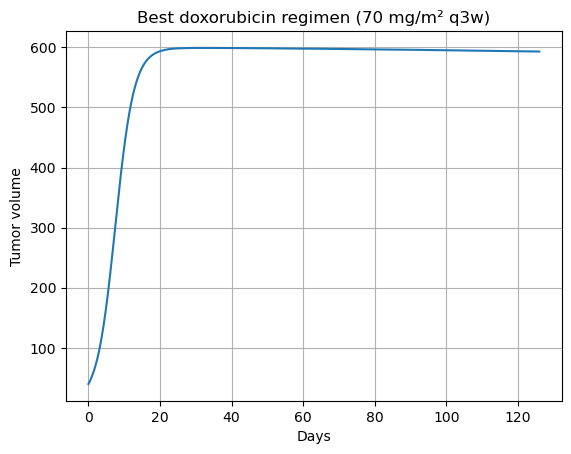

In [203]:
plt.plot(best["t"], best["V"])
plt.xlabel("Days")
plt.ylabel("Tumor volume")
plt.title("Best doxorubicin regimen (70 mg/m² q3w)")
plt.grid(True)
plt.show()


In [204]:
def plot_pk_pd_for_result(result, t_end=None, bsa=1.7):

    if t_end is None:
        t_end = float(result["t"][-1])

    pk_profiles = {}

    if "drug" in result and "choices" not in result:
        drug_specs = [(result["drug"], result["interval"], result["dose_abs"])]
    else:
        interval = result.get("interval", "q3w")
        drug_specs = [(dname, interval, dose_abs) for (dname, dose_abs) in result["choices"]]

    for drug, interval, dose_abs in drug_specs:
        C_func, E_max, EC50 = build_single_drug_pkpd(
            drug_name=drug,
            t_end=t_end,
            bsa=bsa,
            dose_abs_override=dose_abs,
            schedule_override=interval,
        )

        t = np.linspace(0, t_end, 800)
        C = np.array([float(C_func(tt)) for tt in t])
        E = E_of_C(C, E_max, EC50)

        pk_profiles[drug] = {
            "t": t,
            "C": C,
            "E": E,
            "E_max": E_max,
            "EC50": EC50
        }

    # ---------- PK ----------
    plt.figure(figsize=(10, 4))
    for drug, prof in pk_profiles.items():
        plt.plot(prof["t"], prof["C"], label=f"{drug}")
    plt.title("PK: концентрация препаратов C(t)")
    plt.xlabel("Days")
    plt.ylabel("C(t)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # ---------- PD ----------
    plt.figure(figsize=(10, 4))
    total_E = np.zeros_like(next(iter(pk_profiles.values()))["E"])
    t = next(iter(pk_profiles.values()))["t"]

    for drug, prof in pk_profiles.items():
        plt.plot(prof["t"], prof["E"], "--", label=f"{drug} (E)")
        total_E += prof["E"]

    plt.plot(t, total_E, label="Суммарный эффект", linewidth=2)
    plt.title("PD: цитотоксический эффект")
    plt.xlabel("Days")
    plt.ylabel("Effect (условн. ед.)")
    plt.grid(True)
    plt.legend()
    plt.show()


In [205]:
from termcolor import colored
import matplotlib.pyplot as plt
import numpy as np

def _unpack_choice_item(item):

    drug = item[0]
    interval = None
    dose_abs = None


    if len(item) == 2:
        dose_abs = float(item[1])

    elif len(item) == 3:
        if isinstance(item[1], str):
            interval = item[1]
            dose_abs = float(item[2])
        else:
            interval = None
            dose_abs = float(item[2])

    elif len(item) >= 4:
        dose_abs = float(item[-1])
        for v in item[1:-1]:
            if isinstance(v, str):
                interval = v
                break

    return drug, interval, dose_abs


def print_grid_summary(result,
                       mode,
                       plot=True,
                       subtype=None,
                       ki67=None,
                       V0=None,
                       use_resistance=False,
                       row_like_for_resistance=None,
                       bsa=1.7):

    if result is None:
        print(colored("❌ Нет подходящих комбинаций (result = None)", "red"))
        return

    print(colored("\n" + "="*70, "yellow"))
    print(colored(f"РЕЗУЛЬТАТ ОПТИМИЗАЦИИ — режим: {mode}", "yellow", attrs=["bold"]))
    print(colored("="*70, "yellow"))


    if mode == "single_drug":
        drug = result.get("drug", "?")
        interval = result.get("interval", "?")
        dose = result.get("dose", "?")
        dose_abs = result.get("dose_abs", "?")
        cycles = result.get("cycles", None)

        print(colored("🧪 Препарат:", "cyan"), drug)
        print(colored("⏱ Интервал:", "cyan"), interval)
        print(colored("💉 Доза (номинальная):", "cyan"), dose)
        print(colored("💉 Доза (абсолютная):", "cyan"), f"{dose_abs:.1f} mg" if isinstance(dose_abs, (int, float)) else dose_abs)
        if cycles is not None:
            print(colored("🔁 Число введений:", "cyan"), cycles)

    elif mode == "single_regimen":
        regimen = result.get("regimen", "?")
        print(colored("🧪 Схема лечения:", "cyan"), regimen)

 
        interval_common = None
        if "choices" in result and result["choices"]:
            intervals = []
            for item in result["choices"]:
                _, interval_i, _ = _unpack_choice_item(item)
                if interval_i is not None:
                    intervals.append(interval_i)
            uniq = sorted(set(intervals))
            if len(uniq) == 1:
                interval_common = uniq[0]

        print(colored("⏱ Интервал:", "cyan"), interval_common if interval_common else "разные по препаратам")

    elif mode == "auto_best":
        regimen = result.get("regimen", "?")
        print(colored("⭐ Лучшая схема среди рекомендованных:", "cyan"), regimen)

   
        interval_common = None
        if "choices" in result and result["choices"]:
            intervals = []
            for item in result["choices"]:
                _, interval_i, _ = _unpack_choice_item(item)
                if interval_i is not None:
                    intervals.append(interval_i)
            uniq = sorted(set(intervals))
            if len(uniq) == 1:
                interval_common = uniq[0]

        print(colored("⏱ Интервал:", "cyan"), interval_common if interval_common else "разные по препаратам")


    if subtype is not None or ki67 is not None or V0 is not None:
        print(colored("\n👤 Пациент:", "magenta"))
        if subtype is not None:
            print(" • Подтип:", subtype)
        if ki67 is not None:
            print(" • Ki-67:", ki67)
        if V0 is not None:
            print(" • Стартовый объём (введён):", V0)


    if "choices" in result and isinstance(result["choices"], (list, tuple)) and result["choices"]:
        print(colored("\n💊 Препараты и дозы:", "cyan"))
 
        t_vec = result.get("t", None)
        t_end = float(t_vec[-1]) if isinstance(t_vec, (list, np.ndarray)) and len(t_vec) > 0 else None

        for item in result["choices"]:
            drug_name, interval, dose_abs = _unpack_choice_item(item)

    
            n_cycles = None
            if t_end is not None and interval is not None:
                try:
                    n_cycles = count_cycles(interval, t_end, drug_name)
                except Exception:
                    n_cycles = None

            line = f" • {drug_name}: {dose_abs:.1f} mg"
            if interval:
                line += f"  (интервал: {interval}"
                if n_cycles is not None:
                    line += f", введений: {n_cycles}"
                line += ")"
            print(line)

    t = result.get("t", None)
    V = result.get("V", None)

    if t is not None and V is not None and len(t) > 1 and len(V) > 1:
        t = np.array(t, dtype=float)
        V = np.array(V, dtype=float)

        V0_model = V[0]
        V_final = V[-1]
        V_min = np.min(V)
        t_min = t[np.argmin(V)]


        if V0_model > 0:
            delta_final_pct = (V0_model - V_final) / V0_model * 100.0
            delta_min_pct = (V0_model - V_min) / V0_model * 100.0
        else:
            delta_final_pct = np.nan
            delta_min_pct = np.nan

        print(colored("\n📊 Динамика опухоли", "magenta", attrs=["bold"]))

        if plot:
            plt.figure(figsize=(8, 5))
            plt.plot(t, V, label="Tumor volume", linewidth=2)
            plt.xlabel("Days")
            plt.ylabel("Tumor volume")
            plt.title("Tumor dynamics — optimized scenario")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

    print(colored("="*70 + "\n", "yellow"))



РЕЗУЛЬТАТ ОПТИМИЗАЦИИ — режим: single_regimen
🧪 Схема лечения: AC
⏱ Интервал: q3w

💊 Препараты и дозы:
 • doxorubicin: 119.0 mg  (интервал: q3w, введений: 6)
 • cyclophosphamide: 1105.0 mg  (интервал: q3w, введений: 6)

📊 Динамика опухоли


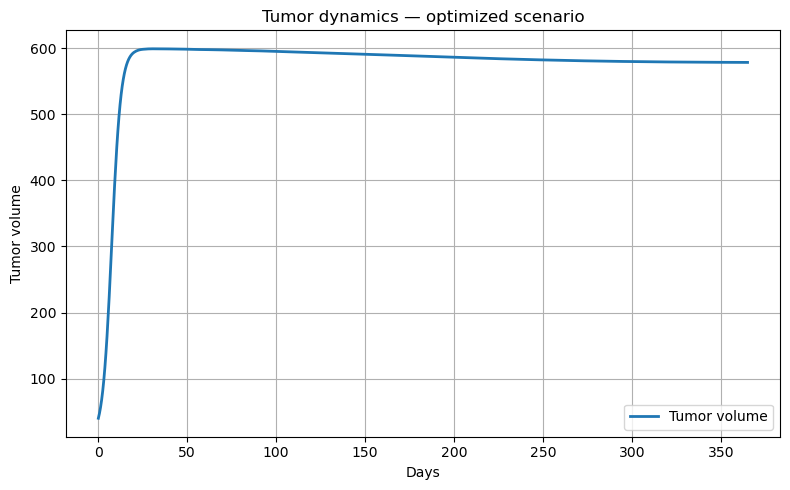

In [206]:
res = grid_search_regimen(
    subtype="TNBC",
    ki67=60,
    V0=40,
    regimen_name="AC",
    t_end=365,
    use_resistance=False
)

print_grid_summary(res, mode="single_regimen")



РЕЗУЛЬТАТ ОПТИМИЗАЦИИ — режим: single_regimen
🧪 Схема лечения: AC
⏱ Интервал: q3w

👤 Пациент:
 • Подтип: TNBC
 • Ki-67: 60
 • Стартовый объём (введён): 40

💊 Препараты и дозы:
 • doxorubicin: 119.0 mg  (интервал: q3w, введений: 6)
 • cyclophosphamide: 1105.0 mg  (интервал: q3w, введений: 6)

📊 Динамика опухоли


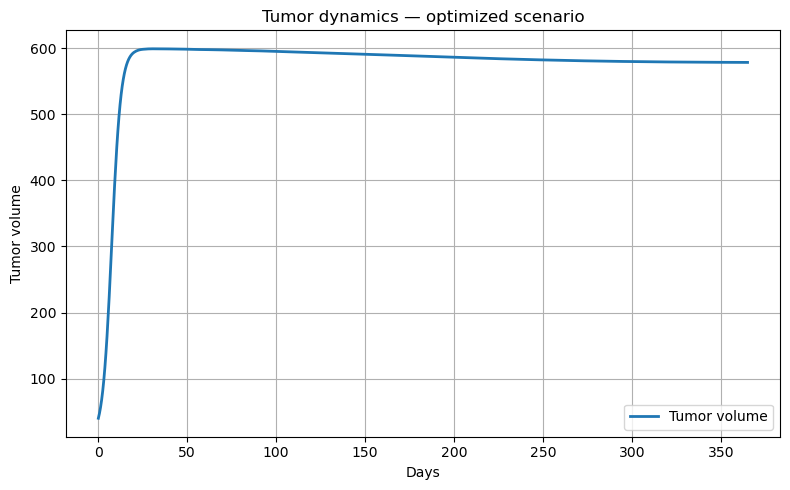

In [207]:
res = grid_search_regimen(
    subtype="TNBC",
    ki67=60,
    V0=40,
    regimen_name="AC",
    t_end=365,
    use_resistance=True
)

print_grid_summary(
    res,
    mode="single_regimen",
    subtype="TNBC",
    ki67=60,
    V0=40,
    use_resistance=True
)



РЕЗУЛЬТАТ ОПТИМИЗАЦИИ — режим: single_drug
🧪 Препарат: doxorubicin
⏱ Интервал: q3w
💉 Доза (номинальная): 70
💉 Доза (абсолютная): 119.0 mg
🔁 Число введений: 6

👤 Пациент:
 • Подтип: TNBC
 • Ki-67: 60
 • Стартовый объём (введён): 40

📊 Динамика опухоли


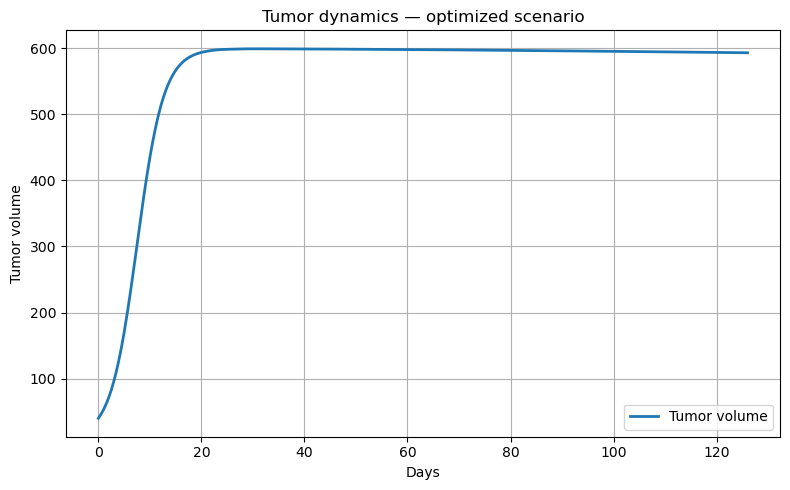

In [208]:
res_sd = grid_search_single_drug(
    subtype="TNBC",
    ki67=60,
    V0=40,
    drug_name="doxorubicin",
    doctor_fixed_interval="q3w",
    t_end=365,
    use_resistance=True
)

print_grid_summary(
    res_sd,
    mode="single_drug",
    subtype="TNBC",
    ki67=60,
    V0=40,
    use_resistance=True
)


In [209]:
def evaluate_model_accuracy(df):

    treatment_to_regimen = {
        "no_treatment": None,
        "surgery_only": None,              # хирургия → считаем как no_treatment
        "surgery_chemo": "AC",             # условное соответствие
        "surgery_target": "T_paclitaxel",
        "TC": "TC",
        "AC": "AC",
        "AC_T": "AC_T",
        "T_paclitaxel": "T_paclitaxel",
        "T_mono": "T_mono",
        "LET": "LET",
        "TAM": "TAM",
        "ANA": "ANA",
        "PLATINUM": "PLATINUM",
    }

    def diameter_to_volume(d):
        return (d**3) * np.pi / 6 if d > 0 else np.nan

    def volume_to_diameter(V):
        return (6*V/np.pi)**(1/3) if V > 0 else np.nan

    relative_errors = []

    for idx, row in df.iterrows():
        try:
            subtype = row["subtype"]
            ki67 = row["ki67_level"]
            d0 = row["tumor_size_before"]
            treatment = row["treatment"]
            regimen = treatment_to_regimen.get(treatment, None)

            if pd.isna(d0) or d0 <= 0:
                continue

            V0 = diameter_to_volume(d0)

            # Моделируем динамику
            t_end = 365
            t_sim, V_sim, *rest = simulate_patient(
                subtype=subtype,
                ki67_percent=ki67,
                V0=V0,
                regimen_name=regimen,
                t_end=t_end,
                use_resistance=False
            )

            months = [3,6,12,24]
            real = []
            pred = []

            for m in months:
                d_real = row.get(f"tumor_size_{m}m", np.nan)
                if pd.isna(d_real) or d_real <= 0:
                    continue

                real.append(d_real)
                V_pred = np.interp(m*30, t_sim, V_sim)
                d_pred = volume_to_diameter(V_pred)
                pred.append(d_pred)

            if len(real) == 0:
                continue

            errs = [abs(p - r) / r for p, r in zip(pred, real)]
            relative_errors.extend(errs)

        except Exception:
            continue

    if len(relative_errors) == 0:
        return {
            "mean_relative_error": np.nan,
            "within_10_percent": 0.0,
            "within_20_percent": 0.0,
            "n_evaluated": 0
        }

    re = np.array(relative_errors)

    return {
        "mean_relative_error": float(np.mean(re)),
        "median_relative_error": float(np.median(re)),
        "within_10_percent": float(np.mean(re < 0.10)),
        "within_20_percent": float(np.mean(re < 0.20)),
        "within_30_percent": float(np.mean(re < 0.30)),
        "n_evaluated": int(len(re))
    }


In [210]:
df_no_tx = df[df["treatment"] == "no_treatment"]

In [211]:
def to_volume_from_diameter(d_cm: float) -> float:
    return (np.pi / 6.0) * (d_cm ** 3)

def to_diameter_from_volume(V: float | np.ndarray) -> float | np.ndarray:
    return (6.0 * V / np.pi) ** (1.0 / 3.0)


def evaluate_growth_model_only(df,
                               subtype_filter=None,
                               use_resistance: bool = False,
                               t_end_days: float = 365.0):

    df_no_tx = df[df["treatment"] == "no_treatment"].copy()

    if subtype_filter is not None:
        df_no_tx = df_no_tx[df_no_tx["subtype"] == subtype_filter]

    if df_no_tx.empty:
        print("Нет пациентов без лечения для заданных условий.")
        return None

    rel_errors = []

    time_points_months = np.array([0, 3, 6, 12])
    time_points_days = time_points_months * 30.0 

    for idx, row in df_no_tx.iterrows():
        try:
            subtype = row["subtype"]
            ki67 = float(row["ki67_level"])

            d_real = np.array([
                row["tumor_size_before"],
                row["tumor_size_3m"],
                row["tumor_size_6m"],
                row["tumor_size_12m"],
            ], dtype=float)

            mask_valid = ~np.isnan(d_real) & (d_real > 0)
            if mask_valid.sum() < 2:
                continue

            V0 = to_volume_from_diameter(d_real[0])

            t_sim, *rest = simulate_patient(
                subtype=subtype,
                ki67_percent=ki67,
                V0=V0,
                regimen_name=None,       
                t_end=t_end_days,
                use_resistance=use_resistance,
                row_like_for_resistance=row
            )

            V_sim = rest[0]

            t_days_valid = time_points_days[mask_valid]
            V_at_points = np.interp(t_days_valid, t_sim, V_sim)

            d_pred = to_diameter_from_volume(V_at_points)

            err = np.abs(d_pred - d_real[mask_valid]) / d_real[mask_valid]
            rel_errors.append(err.mean())

        except Exception as e:
            continue

    if not rel_errors:
        print("Не удалось посчитать ни по одному пациенту.")
        return None

    rel_errors = np.array(rel_errors)

    metrics = {
        "mean_relative_error": float(np.nanmean(rel_errors)),
        "median_relative_error": float(np.nanmedian(rel_errors)),
        "within_10_percent": float((rel_errors < 0.10).mean()),
        "within_20_percent": float((rel_errors < 0.20).mean()),
        "within_30_percent": float((rel_errors < 0.30).mean()),
        "n_evaluated": int(np.sum(~np.isnan(rel_errors))),
    }
    return metrics


In [212]:
metrics_all = evaluate_growth_model_only(df, subtype_filter=None, use_resistance=False)
print(metrics_all)


{'mean_relative_error': 0.6153662619993545, 'median_relative_error': 0.2165523346771464, 'within_10_percent': 0.15, 'within_20_percent': 0.425, 'within_30_percent': 0.6, 'n_evaluated': 40}
